# Recomendação via Fatorização de matrizes (Matrix factorization)

Num projeto anterior, fizemos o completamento de matrizes (por exemplo para sistemas de recomendação como o Netflix) usando uma abordagem *convexa*: algoritmos de otimização de um problema com regularização convexa (norma nuclear).

Uma segunda abordagem bem sucedida é estimar a matriz não observada $X^*$ resolvendo o problema:

$$\min_X f(X)=f(U,V):=\frac 1 2 \|U V^\top - Y\|^2_F,$$

onde $Y\in {\mathbb R}^{m\times n}$ é a matriz observada, $U\in {\mathbb R}^{m\times r}$, $V\in {\mathbb R}^{n\times r}$ and $r<\min\{m,n\}$. O gradiente é dado por

$$
\nabla f(X) = [(UV^\top -Y) V, (UV^\top-Y)^\top U].
$$

Note que diferentemente do caso convexo (onde tínhamos a penalização $\lambda>0$ da norma nuclear como hyper-parâmetro), nesta abordagem temos uma estimativa do posto $r$ como hyper-parâmetro. A idéia aqui é "regularizar" a solução com posto $r$ impondo a fatorização $U V^\top$. Do ponto de vista computacional, a diferença é que o problema é não convexo. Entretanto, algoritmos de otimização iterativos funcionam bem na prática.

Iremos utilizar os dados [Movielens 100K dataset](https://grouplens.org/datasets/movielens/100k/). Em particular usamos o arquivo `u.data` desta pasta, gravado em `~/datasets`. Este arquivo tem avaliações de filmes de 943 usuários e 1682 filmes. Começamos carregando alguns módulos necessários:

In [ ]:
pip install numpy scipy pandas seaborn matplotlib

In [91]:
#Chamando módulos necessários:
import numpy as np
import scipy.linalg as LA
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import scipy.sparse as spr
import scipy.sparse.linalg as spr_LA

À seguir iremos carregar os dados e escrevê-los numa matriz esparsa $Y$.

In [92]:
#Carregando dados:
names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('u.data', sep='\t', names=names)
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]

#Criando a matriz Y de avaliações:
ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]

Y = ratings
m, n = Y.shape
print("As dimensões de Y são:", m, n)

As dimensões de Y são: 943 1682


# Exercício 1: Funções auxiliares

1. Construa uma função `f()` que toma $X=(U,V)$ e retorna o valor funcional $f(X)=\frac 1 2 \|U V^\top - Y\|^2_F$.
2. Construa uma função `df()` que toma $X=(U,V)$ e retorna o gradiente $\nabla f(X) = [(UV^\top -Y) V, (UV^\top-Y)^\top U]$.
3. Construa uma função `J()` que dada matriz $D$ retorna a norma de Frobenius $\Vert D\Vert_F$.

In [93]:
#Escreva código aqui

def f(U, V, Y):
    """
    Calcula a função de erro.

    Parâmetros:
        U (numpy.ndarray): Matriz U de dimensões (m, r).
        V (numpy.ndarray): Matriz V de dimensões (n, r).
        Y (numpy.ndarray): Matriz Y observada de dimensões (m, n).

    Retorna:
        float: Valor funcional.
    """
    return (1/2) * np.linalg.norm(U @ V.T - Y, 'fro')**2

In [94]:
def df(U, V, Y):
    """
    Calcula o gradiente de f(X) com respeito a U e V.

    Parâmetros:
        U (numpy.ndarray): Matriz U de dimensões (m, r).
        V (numpy.ndarray): Matriz V de dimensões (n, r).
        Y (numpy.ndarray): Matriz Y observada de dimensões (m, n).

    Retorna:
        tuple: Gradientes (grad_U, grad_V).
            grad_U: Gradiente com respeito a U, dimensões (m, r).
            grad_V: Gradiente com respeito a V, dimensões (n, r).
    """
    matriz_erro = U @ V.T - Y
    grad_U = matriz_erro @ V
    grad_V = matriz_erro.T @ U
    return grad_U, grad_V

In [95]:
def J(D):
    """
    Calcula a norma de Frobenius de uma matriz D.

    Parâmetros:
        D (numpy.ndarray): Matriz D de dimensões arbitrárias.

    Retorna:
        float: Norma de Frobenius de D.
    """
    return np.linalg.norm(D, 'fro')

# Inicialização

À seguir ponha `r=20` e inicialize $X_0=(U_0,V_0)$ aleatoriamente de uma normal multivariada. Para tanto use
`np.random.randn()`. Ponha `N=30000` para o número de iterações.

In [98]:
r = 20

# the starting point
np.random.seed(0)
U_init = np.random.randn(m, r)
V_init = np.random.randn(n, r)
X0 = (U_init, V_init)


# number of iterations
N = 30000
N_test = 300


# Exercício 2: Método do gradiente

Construa uma função `gd(J, df, x0, la=1, numb_iter=100)` que toma como entrada as funções `J()`, `df`, o ponto inicial `x0`, o passo `la` e o número de iterações `numb_iter` e implementa o método gradiente iniciando de `x0`. Esta função deve retornar a sequência de valores da função `J(df(x))` em cada um dos iterados `x`, isto é, a sequência das normas dos gradientes ao longo da trajetória do método. A função também deve retornar o último iterado.

Implemente a função com passo `la=1./L` com `L=1000`.

In [99]:
#Escreva código aqui
def gd(df, X0, la=1, numb_iter=100):
    """
    Implementa o método do gradiente para minimizar a função.

    Parâmetros:
        df (function): Função que calcula o gradiente.
        X0 (tuple): Ponto inicial (U, V), onde U e V são numpy arrays.
        la (float): Passo de aprendizado (taxa de aprendizado). (default: 1./L com L=1000)
        numb_iter (int): Número de iterações do método. (default: 100)

    Retorna:
        tuple:
            sequence (list): Lista com as normas dos gradientes ao longo das iterações.
            (U, V): O último iterado (U, V).
    """
    # Inicialização
    # Matrizes iniciais U e V
    U, V = X0
    # Lista para armazenar normas do gradiente
    grad_norms = []

    for i in range(numb_iter):
        # Calcula o gradiente
        grad_U, grad_V = df(U, V, Y)

        # Calcula a norma do gradiente atual somando as normas dos dois itens do
        # gradiente, para evitar problemas envolvendo as dimensões das matrizes
        grad_norm = np.sqrt(np.linalg.norm(grad_U, 'fro')**2 + np.linalg.norm(grad_V, 'fro')**2)
        grad_norms.append(grad_norm)

        # Atualiza U e V com o passo de aprendizado
        U = U - la * grad_U
        V = V - la * grad_V

    return grad_norms, (U, V)

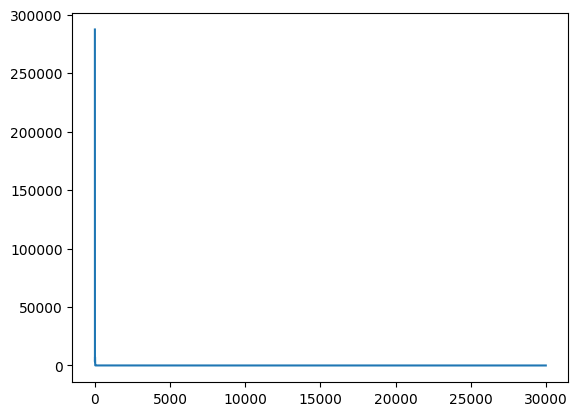

In [57]:
# meu exemplo
L = 1000
f1 = gd(df, X0, 1./L, numb_iter=N)
plt.plot(f1[0])

Time execution for GD: 858.3710577920428


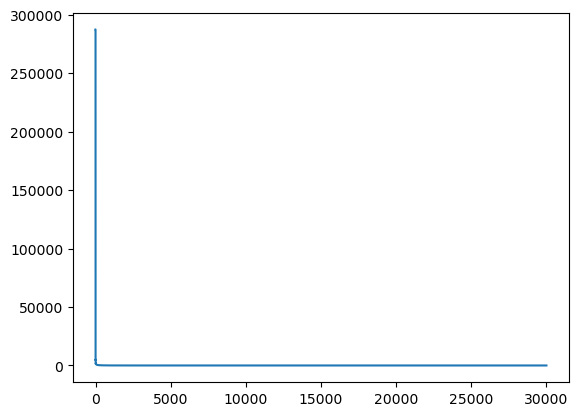

In [ ]:
# gradient descent
L = 1000
f1 = gd(J, df, X0, 1./L, numb_iter=N)
plt.plot(f1[0])

# Exercício 3: Método do gradiente acelerado

Construa uma função `accel_gd(J, df, x0, la=1, numb_iter=100)` que toma como entrada as funções `J()`, `df`, o ponto inicial `x0`, o passo `la` e o número de iterações `numb_iter` e implementa o método gradiente com aceleração de Nesterov iniciando de `y_0=x0` e $t_0=1$:
\begin{align*}
X_{k+1}&:= Y_k - la\nabla f(Y_k),\\
t_{k+1} &:= \frac{1+\sqrt{1+4t_k^2}}{2},\\
Y_{k+1} &:= X_{k+1} + \frac{t_{k}-1}{t_{k+1}}(X_{k+1}-X_{k}).
\end{align*}
Esta função deve retornar a sequência de valores da função `J(df(y))` em cada um dos iterados `y`, isto é, a sequência das normas dos gradientes de $Y_k$ ao longo da trajetória do método. A função também deve retornar o último iterado.

Implemente a função com passo `la=1./L` com `L=30000`.

In [100]:
#Escreva código aqui

def accel_gd(J, df, X0, la=1, numb_iter=100):
    """
    Implementa o método de gradiente acelerado de Nesterov.

    Parâmetros:
        J (function): Função para calcular a norma do gradiente.
        df (function): Função para calcular o gradiente.
        X0 (tuple): Ponto inicial (U, V), onde U e V são numpy arrays.
        la (float): Taxa de aprendizado (default: 1./L com L=30000)
        numb_iter (int): Número de iterações (default: 100)

    Retorna:
        tuple:
            grad_norms (list): Normas dos gradientes ao longo das iterações.
            (U, V): O último iterado (U, V).
    """
    # Inicialização
    U, V = X0  # Matrizes iniciais
    Y_U, Y_V = U.copy(), V.copy()  # Ponto extrapolado inicial
    t_k = 1  # Inicialização de t
    grad_norms = []  # Para armazenar normas dos gradientes

    for _ in range(numb_iter):
        # Calcula o gradiente no ponto extrapolado
        grad_U, grad_V = df(Y_U, Y_V, Y)

        # Atualiza X
        X_U = Y_U - la * grad_U
        X_V = Y_V - la * grad_V

        # Norma do gradiente atual
        grad_norm = np.sqrt(np.linalg.norm(grad_U, 'fro')**2 + np.linalg.norm(grad_V, 'fro')**2)
        grad_norms.append(grad_norm)

        # Atualiza t
        t_next = (1 + np.sqrt(1 + 4 * t_k**2)) / 2

        # Atualiza Y
        Y_U = X_U + (t_k - 1) / t_next * (X_U - U)
        Y_V = X_V + (t_k - 1) / t_next * (X_V - V)

        # Atualiza U, V e t
        U, V = X_U, X_V
        t_k = t_next

    return grad_norms, (U, V)

0.0370767116784209


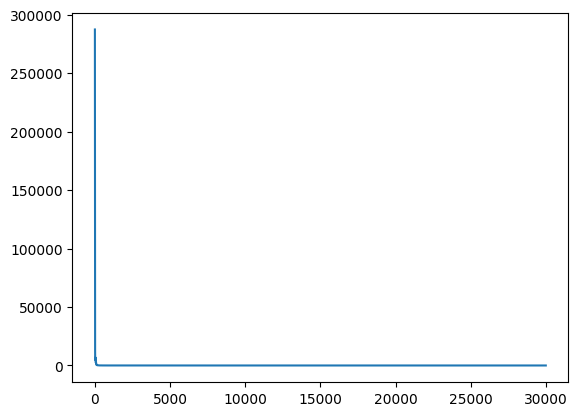

In [59]:
# Meu exemplo
L = 30000
f2 = accel_gd(J, df, X0, 1./L, numb_iter=N)
print(f2[0][-1])
plt.plot(f2[0])

Time execution for accelerated GD: 1946.4800227909582


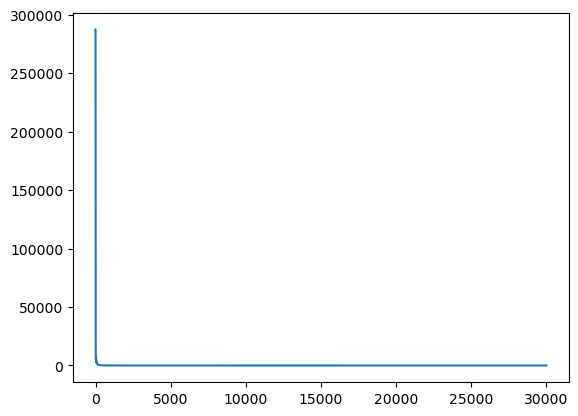

In [ ]:
# Nesterov accelerated gradient descent
L = 30000
f2 = accel_gd(J, df, X0, 1./L, numb_iter=N)
plt.plot(f2[0])

# Exercício 4: Adagrad-Norm

Construa uma função `ad_grad_norm(J, df, x0, b0=0.5, eta=1, numb_iter=100)` que toma como entrada as funções `J()`, `df`, o ponto inicial `x0`, parametros positivos `b0` e `eta` e o número de iterações `numb_iter` e implementa o método Adagrad-Norm iniciando de `x0`:
\begin{align*}
X_{k+1}&:= X_k - \frac{\eta}{\sqrt{b_0^2 + \sum_{j=1}^k\Vert\nabla f(X_j)\Vert_2^2}} \nabla f(X_k).
\end{align*}
Esta função deve retornar a sequência de valores da função `J(df(x))` em cada um dos iterados `x`, isto é, a sequência das normas dos gradientes de $X_k$ ao longo da trajetória do método. A função também deve retornar o último iterado.

Implemente a função com `b0=0.5` e `eta=1`.

In [101]:
#Escreva código aqui

def ad_grad_norm(J, df, x0, b0=0.5, eta=1, numb_iter=100):
    """
    Implementa o método Adagrad-Norm para otimização.

    Parâmetros:
        J (function): Função para calcular a norma de Frobenius.
        df (function): Função para calcular o gradiente.
        x0 (tuple): Ponto inicial (U, V), onde U e V são numpy arrays.
        b0 (float): Termo inicial para o denominador. (default: 0.5.)
        eta (float): Escala para o passo de aprendizado. (default: 1.)
        numb_iter (int): Número máximo de iterações. (default: 100.)

    Retorna:
        tuple:
            grad_norms (list): Sequência de normas dos gradientes.
            (U, V): O último iterado (U, V).
    """
    # Inicialização
    U, V = x0  # Ponto inicial
    grad_norms = []  # Para armazenar as normas dos gradientes
    accumulated_norm = b0**2  # Inicialização do acumulador de norma

    for k in range(numb_iter):
        # Calcula o gradiente
        grad_U, grad_V = df(U, V, Y)

        # Calcula a norma do gradiente
        grad_norm = np.sqrt(np.linalg.norm(grad_U, 'fro')**2 + np.linalg.norm(grad_V, 'fro')**2)
        grad_norms.append(grad_norm)

        # Atualiza o acumulador de norma
        accumulated_norm += grad_norm**2

        # Calcula o passo adaptativo
        step_size = eta / np.sqrt(accumulated_norm)

        # Atualiza U e V
        U = U - step_size * grad_U
        V = V - step_size * grad_V

    return grad_norms, (U, V)

erro final: 4818.941739647327


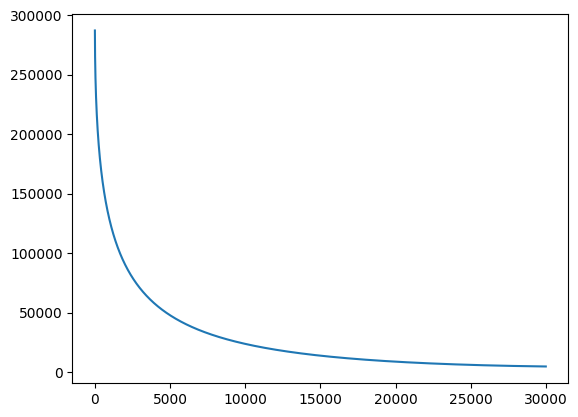

In [61]:
# Meu exemplo
f3 = ad_grad_norm(J, df, X0, b0=0.5, eta=1, numb_iter=N)
print(f"erro final: {f3[0][-1]}")
plt.plot(f3[0])

Time execution for Adagrad-Norm: 1319.619017124991


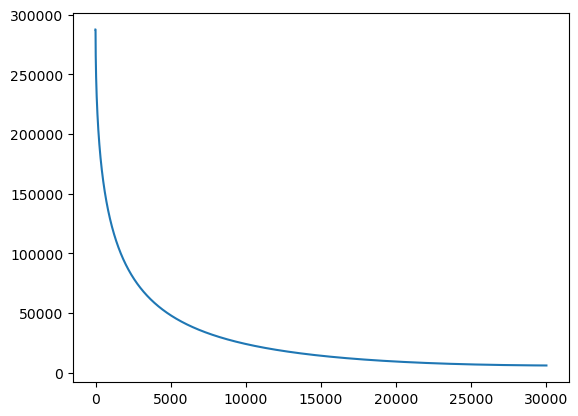

In [ ]:
# Adagrad-Norm
f3 = ad_grad_norm(J, df, X0, b0=0.5, eta=1, numb_iter=N)
plt.plot(f3[0])

# Exercício 5: Adam

Construa uma função `adam(J, df, x0, alpha, beta1, beta2, epsilon, numb_iter)` que toma como entrada as funções `J()`, `df`, o ponto inicial `x0`, parametros positivos `alpha`, `beta1`, `beta2`, `epsilon` e o número de iterações `numb_iter` e implementa o método Adam iniciando de `x0`, $m_0=0$, $v_0=0$ e $k=0$: para cada $j$ézima coordenada:
\begin{align*}
m_{k+1}[j] &:= \beta_1\cdot m_{k}[j] + (1-\beta_1)\cdot\nabla f(X_k)[j],\\
v_{k+1}[j] &:= \beta_2\cdot v_{k}[j] + (1-\beta_2)\cdot(\nabla f(X_k)[j])^2,\\
\hat m_{k+1}[j] &:= \frac{1}{1-\beta_1^{k+1}}m_{k+1}[j],\\
\hat v_{k+1}[j] &:= \frac{1}{1-\beta_2^{k+1}}v_{k+1}[j],\\
X_{k+1}[j] &:= X_{k}[j] - \frac{\alpha}{\sqrt{\hat v_{k+1}[j]} + \epsilon}\hat m_{k+1}[j].
\end{align*}
Esta função deve retornar a sequência de valores da função `J(df(x))` em cada um dos iterados `x`, isto é, a sequência das normas dos gradientes de $X_k$ ao longo da trajetória do método. A função também deve retornar o último iterado.

Implemente a função com `alpha=0.001`, `beta1=0.9`, `beta2=0.999`, `epsilon=10**(-8)`.

In [102]:
#Escreva código aqui
def adam(J, df, X0, alpha=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, numb_iter=100):
    """
    Implementa o método de otimização Adam.

    Parâmetros:
        df (function): Função para calcular o gradiente.
        X0 (tuple): Ponto inicial (U, V), onde U e V são numpy arrays.
        alpha (float): Taxa de aprendizado base. (default: 0.001)
        beta1 (float): Fator de média móvel para o gradiente. (default: 0.9)
        beta2 (float): Fator de média móvel para os quadrados do gradiente. (default: 0.999)
        epsilon (float): Termo para evitar divisão por zero. (default: 1e-8)
        numb_iter (int): Número máximo de iterações. (default: 100)

    Retorna:
        tuple:
            grad_norms (list): Sequência de normas dos gradientes.
            (U, V): O último iterado (U, V).
    """
    # Inicialização
    U, V = X0  # Matrizes iniciais
    m_U, m_V = np.zeros_like(U), np.zeros_like(V)  # Inicialização de m (primeiro momento)
    v_U, v_V = np.zeros_like(U), np.zeros_like(V)  # Inicialização de v (segundo momento)
    grad_norms = []  # Para armazenar normas dos gradientes

    for k in range(numb_iter):
        # Calcula o gradiente
        grad_U, grad_V = df(U, V, Y)

        # Norma do gradiente
        grad_norm = np.sqrt(np.linalg.norm(grad_U, 'fro')**2 + np.linalg.norm(grad_V, 'fro')**2)
        grad_norms.append(grad_norm)

        # Atualiza m (primeiro momento)
        m_U = beta1 * m_U + (1 - beta1) * grad_U
        m_V = beta1 * m_V + (1 - beta1) * grad_V

        # Atualiza v (segundo momento)
        v_U = beta2 * v_U + (1 - beta2) * (grad_U**2)
        v_V = beta2 * v_V + (1 - beta2) * (grad_V**2)

        # Corrige o viés
        m_U_hat = m_U / (1 - beta1**(k + 1))
        m_V_hat = m_V / (1 - beta1**(k + 1))
        v_U_hat = v_U / (1 - beta2**(k + 1))
        v_V_hat = v_V / (1 - beta2**(k + 1))

        # Atualiza os parâmetros
        U = U - alpha * m_U_hat / (np.sqrt(v_U_hat) + epsilon)
        V = V - alpha * m_V_hat / (np.sqrt(v_V_hat) + epsilon)

    return grad_norms, (U, V)

erro final: 25.168000554810142


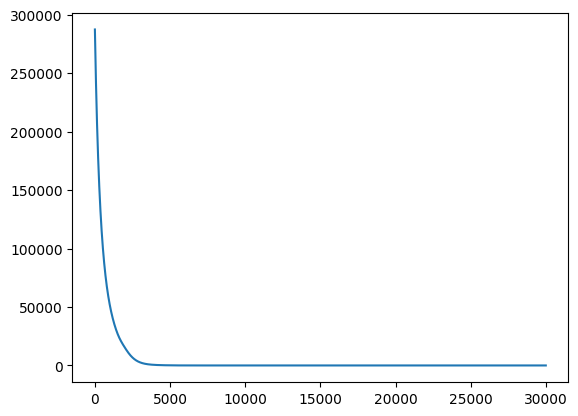

In [63]:
# Meu exemplo
# Armazenar os f's
f4 = adam(df, X0, alpha=0.001, beta1=0.9, beta2=0.999, epsilon=10**(-8), numb_iter=N)
print(f"erro final: {f4[0][-1]}")
plt.plot(f4[0])

Time execution for Adam: 469.3917962079868


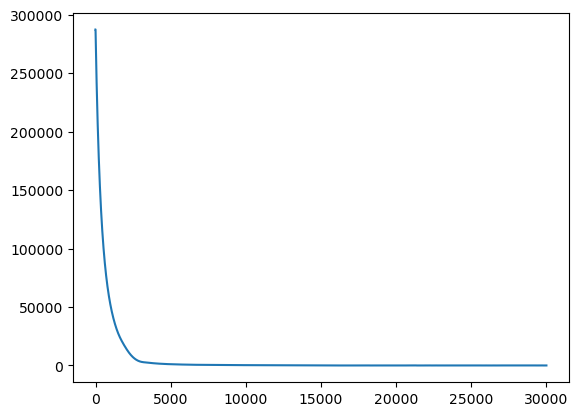

In [ ]:
# Adam
f4 = adam(J, df, X0, alpha=0.001, beta1=0.9, beta2=0.999, epsilon=10**(-8), numb_iter=N)
plt.plot(f4[0])

# Exercício 6:

Implemente num mesmo gráfico os erros $\Vert\nabla f(X_k)\Vert$ de cada método em função no número de iterações.

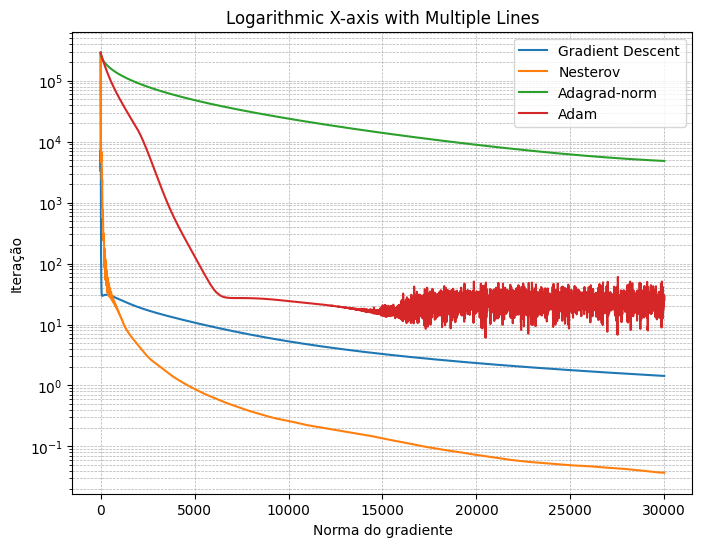

In [65]:
# Create the plot
plt.figure(figsize=(8, 6))

# Plot the lines
plt.plot(f1[0], label='Gradient Descent')
plt.plot(f2[0], label='Nesterov')
plt.plot(f3[0], label='Adagrad-norm')
plt.plot(f4[0], label='Adam')

# Set x-axis to log scale
plt.yscale('log')

# Add a manually set legend
plt.legend(['Gradient Descent', 'Nesterov', 'Adagrad-norm', 'Adam'])

# Add labels and title
plt.xlabel('Norma do gradiente')
plt.ylabel('Iteração')
plt.title('Logarithmic X-axis with Multiple Lines')

# Show the plot
plt.grid(True, which="both", linestyle="--", linewidth=0.5)  # Optional: Add grid lines for clarity
plt.show()

# Exercício 7:

Experimente com os hyper-parâmetros de Adagrad-Norm e Adam para ver se eles podem chegar perto ou superar a performance de GD e Nesterov. Plote o gráfico como no Exercício 6.

A seguinte função cria uma função "geral", onde posso usar qualquer um dos métodos de otimização.

In [66]:
def evaluate_method(method, J, df, x0, Y, params, numb_iter=100):
    """
    Avalia um método de otimização com um conjunto de hiperparâmetros.

    Parameters:
        method (function): Método de otimização (e.g., gd, accel_gd, ad_grad_norm, adam).
        J (function): Função para calcular a norma do gradiente.
        df (function): Função para calcular o gradiente.
        x0 (tuple): Ponto inicial (U, V).
        Y (numpy.ndarray): Matriz observada.
        params (dict): Hiperparâmetros para o método.
        numb_iter (int): Número de iterações.

    Returns:
        float: Erro final (norma de Frobenius do erro \( Y - UV^\top \)).
    """
    grad_norms, (U_final, V_final) = method(J, df, x0, **params, numb_iter=numb_iter)
    # Calcula o erro final
    error_matrix = U_final @ V_final.T - Y
    return np.linalg.norm(error_matrix, 'fro')


E utilizarei a técnica de grid-search para encontrar a melhor combinação de hiper parâmetros para adagrad-norm e adam.

In [78]:
from itertools import product

def grid_search(J, df, x0, method, param_grid, numb_iter=300):
    """
    Realiza busca em grade para encontrar os melhores hiperparâmetros.

    Parameters:
        J (function): Função para calcular a norma do gradiente.
        df (function): Função para calcular o gradiente.
        x0 (tuple): Ponto inicial (U, V).
        method (function): Método de otimização (e.g., gd, accel_gd, ad_grad_norm, adam).
        param_grid (dict): Grade de hiperparâmetros para testar.
        numb_iter (int): Número de iterações.

    Returns:
        dict: Melhor combinação de parâmetros e o erro correspondente.
    """
    keys, values = zip(*param_grid.items())
    best_params = None
    best_error = float('inf')

    for combination in product(*values):
        params = dict(zip(keys, combination))
        error = evaluate_method(method, J, df, x0, Y, params, numb_iter=numb_iter)
        print(f"Tested params: {params}, Error: {error}")

        if error < best_error:
            best_error = error
            best_params = params

    return {'best_params': best_params, 'best_error': best_error}

Vou procurar os melhores hiper-parâmetros apenas para adgrad e adam, deixando gd e nesterov como estão.

In [112]:
# Parâmetros para Adagrad-Norm
param_grid_adagrad = {
    'b0': [0.1, 0.5, 1.0],
    'eta': [0.1, 0.5, 1.0]
}

# Parâmetros para Adam
param_grid_adam = {
    'alpha': [0.0001, 0.001, 0.01],
    'beta1': [0.8, 0.9],
    'beta2': [0.9, 0.999],
    'epsilon': [1e-8, 1e-6]
}

# Executa busca em grade para cada método
print("Adagrad-Norm:")
best_adagrad = grid_search(J, df, X0, ad_grad_norm, param_grid_adagrad)

print("Adam:")
best_adam = grid_search(J, df, X0, adam, param_grid_adam)

# Resultados
print("Best Adagrad-Norm:", best_adagrad)
print("Best Adam:", best_adam)

Adagrad-Norm:
Tested params: {'b0': 0.1, 'eta': 0.1}, Error: 5535.546986399804
Tested params: {'b0': 0.1, 'eta': 0.5}, Error: 4926.444970523641
Tested params: {'b0': 0.1, 'eta': 1.0}, Error: 4268.623535920838
Tested params: {'b0': 0.5, 'eta': 0.1}, Error: 5535.546986399822
Tested params: {'b0': 0.5, 'eta': 0.5}, Error: 4926.444970523725
Tested params: {'b0': 0.5, 'eta': 1.0}, Error: 4268.623535920991
Tested params: {'b0': 1.0, 'eta': 0.1}, Error: 5535.546986399878
Tested params: {'b0': 1.0, 'eta': 0.5}, Error: 4926.4449705239895
Tested params: {'b0': 1.0, 'eta': 1.0}, Error: 4268.623535921472
Adam:
Tested params: {'alpha': 0.0001, 'beta1': 0.8, 'beta2': 0.9, 'epsilon': 1e-08}, Error: 5441.314339076288
Tested params: {'alpha': 0.0001, 'beta1': 0.8, 'beta2': 0.9, 'epsilon': 1e-06}, Error: 5441.31433933415
Tested params: {'alpha': 0.0001, 'beta1': 0.8, 'beta2': 0.999, 'epsilon': 1e-08}, Error: 5445.80323738988
Tested params: {'alpha': 0.0001, 'beta1': 0.8, 'beta2': 0.999, 'epsilon': 1e-06

In [113]:
# Refazendo f3 e f4 com os melhores parâmetros encontrados

f3 = ad_grad_norm(J, df, X0, **best_adagrad['best_params'], numb_iter=N)
print(f"erro final: {f3[0][-1]}")

erro final: 5886.964038229865


In [114]:
f4 = adam(J, df, X0, **best_adam['best_params'], numb_iter=N)
print(f"erro final: {f4[0][-1]}")

erro final: 42.13272841203639


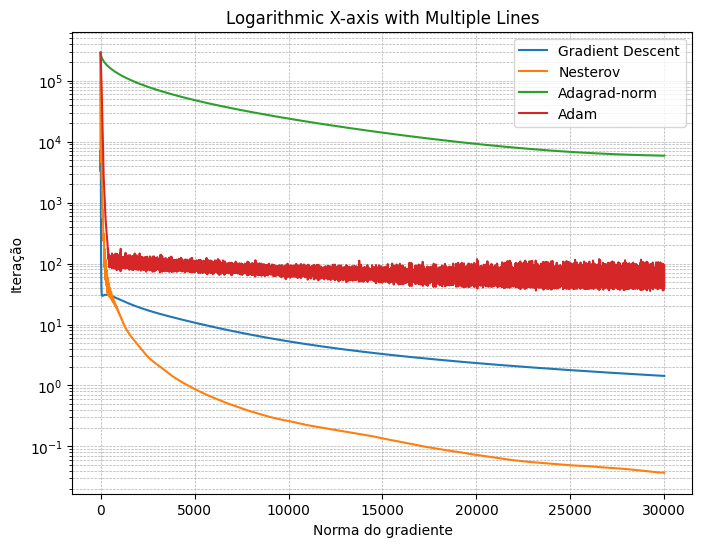

In [116]:
# Create the plot
plt.figure(figsize=(8, 6))

# Plot the lines
plt.plot(f1[0], label='Gradient Descent')
plt.plot(f2[0], label='Nesterov')
plt.plot(f3[0], label='Adagrad-norm')
plt.plot(f4[0], label='Adam')

# Set x-axis to log scale
plt.yscale('log')

# Add a manually set legend
plt.legend(['Gradient Descent', 'Nesterov', 'Adagrad-norm', 'Adam'])

# Add labels and title
plt.xlabel('Norma do gradiente')
plt.ylabel('Iteração')
plt.title('Logarithmic X-axis with Multiple Lines')

# Show the plot
plt.grid(True, which="both", linestyle="--", linewidth=0.5)  # Optional: Add grid lines for clarity
plt.show()

Aqui, podemos ver que mesmo tentando fazer um refinamento dos hiper-parâmetros, ainda não conseguimos atingir uma performance melhor utilizando os métodos de adagrad-norm e Adam